# Annuiteettilainan havainnollistaminen

Olen saanut tähän ideat artikkelista http://pbpython.com/amortization-model-revised.html.

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from datetime import date
from dateutil.relativedelta import *

sns.set_style('darkgrid')

In [2]:
def generoi_lyhennys(laina, korkokanta, aika_vuosina, maksuerä, ylim_maksu, 
             aloitus_päivä, maksueriä_vuodessa):

    '''Generator tyyppinen funktio generoi lyhennykset ja korot ja palauttaa tiedot 
    OrderedDict-oliona.
    ylim_maksu: ylimääräinen lyhennys, joka tehdään jokaisen maksuerän yhteydessä.'''

    p = 1   # periodi
    ennen_lyhennystä = laina   # Laina ennen maksuerää
    lyhennyksen_jälkeen = laina   # Laina maksuerän jälkeen
    
    while lyhennyksen_jälkeen > 0: 
        
        korko = round(((korkokanta/maksueriä_vuodessa) * ennen_lyhennystä), 2)
        maksuerä = min(maksuerä, ennen_lyhennystä + korko)
        lyhennys = maksuerä - korko   # Tämän verran lainaa lyhennetään
        ylim_maksu = min(ylim_maksu, ennen_lyhennystä - lyhennys)
        lyhennyksen_jälkeen = ennen_lyhennystä - (lyhennys + ylim_maksu)

        yield OrderedDict([('Jakso', p),
                           ('Kuukausi', aloitus_päivä),
                           ('Laina ennen lyhennystä', ennen_lyhennystä),
                           ('Maksuerä', maksuerä),
                           ('Korko', korko),
                           ('Lyhennys', lyhennys),
                           ('Ylimääräinen lyhennys', ylim_maksu),
                           ('Laina lyhennyksen jälkeen', lyhennyksen_jälkeen)])
        
        p += 1
        aloitus_päivä += relativedelta(months=1) # Sama päivä seuraavassa kuussa
        ennen_lyhennystä = lyhennyksen_jälkeen
        


def lyhennys_taulukko(laina, korkokanta, aika_vuosina, ylim_maksu=0, 
                      maksueriä_vuodessa=12, aloitus_päivä=date.today()):
    
    '''lyhennys_taulukko kutsuu lyhennys-funktiota, sijoittaa tulokset 
    dataframeen ja laskee lainaan liittyviä tilastotietoja.'''
       
    # Käytetään valmista numpy-financal pmt-funktiota maksuerän laskemiseen
    maksuerä = -round(npf.pmt(korkokanta/maksueriä_vuodessa, 
                              aika_vuosina*maksueriä_vuodessa, laina), 2)
    
    # Lyhennys-funktion tulokset dataframeen
    taulukko = pd.DataFrame(generoi_lyhennys(laina, korkokanta, aika_vuosina, maksuerä,
                                     ylim_maksu, aloitus_päivä, maksueriä_vuodessa))
       
    # Varmistetaan, että Python tunnistaa päivämäärät päivämääriksi
    taulukko['Kuukausi'] = pd.to_datetime(taulukko['Kuukausi'])
    
    # Tilastotietoja
    loppu_päivä = taulukko['Kuukausi'].iloc[-1]
    tiedot = pd.Series([loppu_päivä, taulukko['Jakso'].count(), korkokanta,
                       aika_vuosina, laina, maksuerä, ylim_maksu,
                       taulukko['Korko'].sum()],
                       index = ['Loppupäivä', 'Maksujen lukumäärä', 'Korkokanta', 
                                'Aika vuosina', 'Lainan suuruus', 'Maksuerä', 
                                'Ylimääräinen lyhennys', 'Korot yhteensä'])
    
    return taulukko, tiedot



def korot(taulukko, tiedot):
    
    '''Muodostaa dataframen koroista.'''
    
    y = taulukko.set_index('Kuukausi')['Korko'].resample('A').sum().reset_index()
    y['Vuosi'] = y['Kuukausi'].dt.year
    y.set_index('Vuosi', inplace=True)
    y.drop('Kuukausi', axis=1, inplace=True)
    otsikko='{} vuotta, korkokanta {} % , lisälyhennys  {} €'.format(tiedot['Aika vuosina'], 
                                tiedot['Korkokanta']*100, tiedot['Ylimääräinen lyhennys'])
    return y, otsikko

## Koko laina-ajan tiedot

In [3]:
# Määritä lainan parametrit!
taulukko, tiedot = lyhennys_taulukko(laina=300000, korkokanta=.0245, 
                                     aika_vuosina=35, aloitus_päivä=date(2022, 1, 1))

tiedot

Loppupäivä               2057-01-01 00:00:00
Maksujen lukumäärä                       421
Korkokanta                            0.0245
Aika vuosina                              35
Lainan suuruus                        300000
Maksuerä                             1064.46
Ylimääräinen lyhennys                      0
Korot yhteensä                      147075.2
dtype: object

## Tietyn periodin tiedot

In [4]:
# Määritä periodi!
periodi = 5

taulukko.iloc[periodi-1]

Jakso                                          5
Kuukausi                     2022-05-01 00:00:00
Laina ennen lyhennystä                 298186.62
Maksuerä                                 1064.46
Korko                                      608.8
Lyhennys                                  455.66
Ylimääräinen lyhennys                          0
Laina lyhennyksen jälkeen              297730.96
Name: 4, dtype: object

## Vaihtoehtolaskelmia

In [5]:
# Määritä vaihtoehtojen parametrit!
taulukko1, tiedot1 = lyhennys_taulukko(laina=300000, korkokanta=.0245, aika_vuosina=35, 
                                       ylim_maksu=0, aloitus_päivä=date(2022, 1, 1))
taulukko2, tiedot2 = lyhennys_taulukko(laina=300000, korkokanta=.0245, aika_vuosina=25, 
                                       ylim_maksu=0, aloitus_päivä=date(2022, 1, 1))
taulukko3, tiedot3 = lyhennys_taulukko(laina=300000, korkokanta=.0400, aika_vuosina=25, 
                                       ylim_maksu=0, aloitus_päivä=date(2022, 1, 1))

# Vaihtoehtolaskelmien tilastotiedot taulukkona
pd.DataFrame([tiedot1, tiedot2, tiedot3])

,Loppupäivä,Maksujen lukumäärä,Korkokanta,Aika vuosina,Lainan suuruus,Maksuerä,Ylimääräinen lyhennys,Korot yhteensä
0,2057-01-01,421,0.0245,35,300000,1064.46,0,147075.20
1,2046-12-01,300,0.0245,25,300000,1338.31,0,101492.36
2,2047-01-01,301,0.0400,25,300000,1583.51,0,175053.18


Text(0.5, 1.0, 'Lainaa jäljellä')

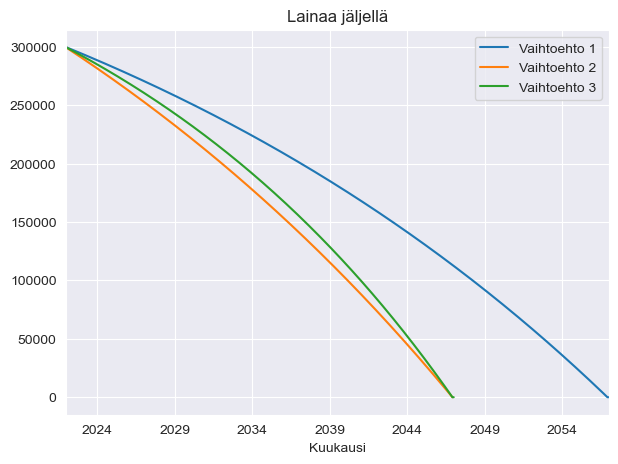

In [6]:
# Jäljellä olevan lainan havainnollistaminen
fig, ax = plt.subplots(1, 1, figsize=(7,5))
taulukko1.plot(x='Kuukausi', y='Laina lyhennyksen jälkeen',
               label='Vaihtoehto 1', ax=ax)
taulukko2.plot(x='Kuukausi', y='Laina lyhennyksen jälkeen', 
               label='Vaihtoehto 2', ax=ax)
taulukko3.plot(x='Kuukausi', y='Laina lyhennyksen jälkeen', 
               label='Vaihtoehto 3', ax=ax)
ax.set_title('Lainaa jäljellä')

Text(0.5, 1.0, 'Maksetut korot')

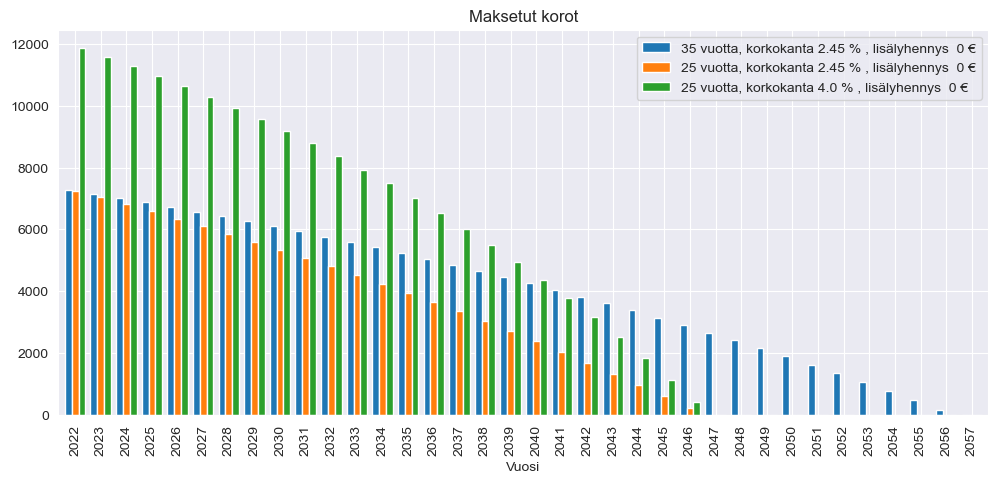

In [7]:
# Korot grafiikkana

y1, otsikko1 = korot(taulukko1, tiedot1)
y2, otsikko2 = korot(taulukko2, tiedot2)
y3, otsikko3 = korot(taulukko3, tiedot3)
y = pd.concat([y1, y2, y3], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
y.plot.bar(width=0.8, ax=ax)
ax.legend([otsikko1, otsikko2, otsikko3])
ax.set_title('Maksetut korot')

## Ylimääräisteen lyhennysten vaikutus lainan lyhenemiseen

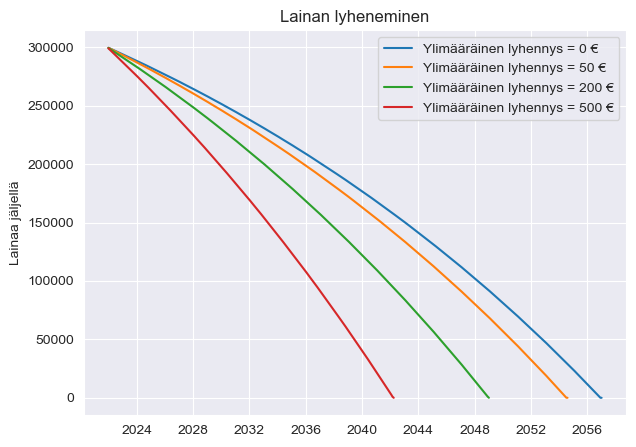

In [8]:
ylim_maksut = [0, 50, 200, 500]
fig, ax = plt.subplots(1, 1, figsize=(7,5))

for maksu in ylim_maksut:
    taulukko, _ = lyhennys_taulukko(laina=300000, korkokanta=.0245, aika_vuosina=35, 
                                    ylim_maksu=maksu, aloitus_päivä=date(2022, 1, 1))
    ax.plot(taulukko['Kuukausi'], taulukko['Laina lyhennyksen jälkeen'], 
            label='Ylimääräinen lyhennys = {} €'.format(str(maksu)))
ax.set_title('Lainan lyheneminen')
ax.set_ylabel('Lainaa jäljellä')
ax.legend()